<a href="https://colab.research.google.com/github/baleineindigo/Statistic/blob/main/%EC%A0%95%EA%B7%9C%ED%99%94%ED%9A%8C%EA%B7%80%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
import statsmodels.api as sm
import matplotlib.font_manager as fm

# # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

# # GPU 설정 : 런타임 > 런타임 유형 변경 > GPU
# # GPU 사용 가능한지 확인
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# 정규화 회귀모형

선형회귀는 결과를 직관적으로 해석할 수 있고 OLS 적용이 가능하지만, 때로는 비선형 다항회귀가 데이터를 더 잘 추정한다.

그러나 비선형 다항함수의 경우 과적합의 문제가 발생할 수 있다. 이때, 과적합 문제를 완화하기 위한 방법은 아래와 같다.

1) 모형 복잡도 줄이기
\
2) 정규화(Regularization)
\
\
** 정규화(Regularization) **
특정 변수의 계수값이 특히 높거나 낮을 때 해당 변수에 의해 결과가 좌우될 수 있음. 이러한 현상을 완화하기 위해 정규화 적용.

In [ ]:
## 데이터 셋
def make_nonlinear(seed=0):
    np.random.seed(seed)
    n_samples=30
    X=np.sort(np.random.rand(n_samples))
    Y=np.sin(2*np.pi*X)+np.random.rand(n_samples)*0.1
    # X=X[:np.newaxis]
    return (X,Y)

X,Y=make_nonlinear()
dfX=pd.DataFrame(X,columns=["x"])
dfX=sm.add_constant(dfX)
dfY=pd.DataFrame(Y,columns=["y"])
df=pd.concat([dfX,dfY],axis=1)
df.head()

In [ ]:
formula_str="y ~ x "
for i in range(2,10):
    formula_str+=" + I(x**{})".format(i)

print(formula_str)
model0=sm.OLS.from_formula(formula_str, data=df)
result0=model0.fit()
# print(result0.summary())
print(result0.params)

In [ ]:
# 비선형 모형
def plot_statsmodels(result):
    plt.scatter(X, Y,c="c")
    xx = np.linspace(0, 1, 1000)
    dfxx = pd.DataFrame(xx, columns=["x"])
    dfxx = sm.add_constant(dfxx)
    plt.plot(xx, result.predict(dfxx).values,c="r")
    plt.show()


plot_statsmodels(result0)

### 정규화 회귀 방법론 1
**Ridge Regression**

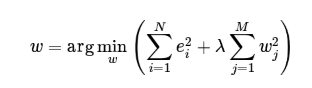
\
- 람다가 0에 근사하면 OLS 적용이 가능한 선형회귀식에 가까워짐

- 람다가 증가하면 계수의 크기가 줄어든다.

- 다중공선성을 방지하기 위해 사용할 수 있다. 

- 큰 계수 값이 더 크게 축소되고, 전체 계수가 점점 비슷한 수치로 수렴.

- 패널티 항(람다*가중치 합)은 미분이 가능하여 최적화 가능

In [ ]:
# 모수 L1_wt가 0 이면 순수 Ridge 모형
result_R=model0.fit_regularized(alpha=0.01,L1_wt=0)
print(result_R.params)
plot_statsmodels(result_R)

In [ ]:
def plot_sklearn(model):
    plt.scatter(X, Y)
    xx = np.linspace(0, 1, 1000)
    plt.plot(xx, model.predict(xx[:, np.newaxis]))
    plt.show()


## Scikit-Learn으로 Ridge 정규화
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
''' Signature: make_pipeline(*steps, **kwargs)
Docstring:Construct a Pipeline from the given estimators.'''
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

poly = PolynomialFeatures(9)
result_Lin = make_pipeline(poly, LinearRegression()).fit(df[["x"]],df[["y"]])
print(result_Lin.steps[1][1].coef_)
plot_sklearn(result_Lin)

### 정규화 회귀 방법론 2
**Lasso Regression**

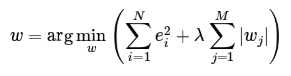
\
- 람다가 0에 근사하면 작은 계수는 0이 된다. 따라서 데이터 대비  변수개수가 많을 때는 Lasso로 변수 선정을 할 수 있다.

- 다만, 정보 손실로 Ridge보다 정확성이 떨어질 수 있다.

- 파라미터 크기에 관계없이 같은 수준의 정규화가 이뤄져, 특정 값은 먼저 0으로 수렴한다.

In [ ]:
# 모수 L1_wt가 1 이면 순수 Lasso 모형
result_L=model0.fit_regularized(alpha=0.01,L1_wt=1)
print(result_L.params)
plot_statsmodels(result_L)

In [ ]:
## Scikit-Learn으로 Lasso 정규화
result_Rsk = make_pipeline(poly, Lasso(alpha=0.01)).fit(df[["x"]],df[["y"]])
print(result_Rsk.steps[1][1].coef_)
plot_sklearn(result_Rsk)

### 정규화 회귀 방법론 3
**Elasitc Net Regression**
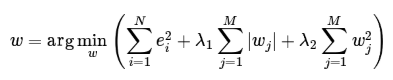
\
- Ridge와 Lasso를 모두 반영. 람다 값을 적절히 조절하여 2개 효과를 볼 수 있다.

- 대용량 데이터에 변수 개수도 많은 데이터 셋에 적합


In [ ]:
# L1_wt가 0과 1 사이이면 Elastic Net 모형
result_E=model0.fit_regularized(alpha=0.01,L1_wt=0.5)
print(result_E.params)
plot_statsmodels(result_E)

In [ ]:
## Scikit-Learn으로 Ridge 정규화
result_Rsk = make_pipeline(poly, ElasticNet(alpha=0.01,l1_ratio=0.5)).fit(df[["x"]],df[["y"]])
print(result_Rsk.steps[1][1].coef_)
plot_sklearn(result_Rsk)


### 최적 정규화

정규화에 사용되는 하이퍼 모수(hyper parameter) 등을 바꾸면 모형의 검증 성능이 달라진다. 따라서 최적의 성능을 가져올 수 있는 정규화 하이퍼 모수를 선택하는 과정이 필요하다. 이러한 과정을 최적 정규화(optimal regularization)라고 한다.

보스턴 집값 데이터에 대해 라쏘 정규화(Lasso regularization)를 하는 경우를 예로 들어보자. 우선 scikit-learn에서 제공하는 Lasso 클래스를 사용하여 정규화를 한다. 정규화 가중치 가 달라지면 학습용 데이터를 사용한 성능과 검증용 데이터를 사용한 성능이 달라진다.

학습용 데이터를 사용한 성능은 정규화 가중치 가 작으면 작을 수록 좋아진다.(과최적화)

검증용 데이터를 사용한 성능은 정규화 가중치 가 특정한 범위에 있을 때 가장 좋아진다.

실제로 정규화 가중치 를 부터 까지 변화시켜가면서 두 성능을 측정해 보자.


In [ ]:
# 데이터셋 마련
from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


boston = load_boston()
bst_X= boston.data
bst_Y= boston.target

alphas = np.logspace(-4, 0, 200)

# 트레이닝셋, 테스트 셋 구축
train_scores=[]
test_scores=[]

for alpha in alphas:
    model3=Lasso(alpha=alpha)
    train_score= -mean_squared_error(Y,model3.fit(df[["x"]],df[["y"]]).predict(df[["x"]]))
    test_score=np.mean(cross_val_score(model3,df[["x"]],df[["y"]],scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)


In [ ]:
## 시각화
plt.plot(alphas, test_scores, "-", label="Test Perf")
plt.plot(alphas, train_scores, "--", label="Training Perf")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("Optimize Regulariztion")
plt.ylabel('Performence')
plt.xlabel('Regulariztion Weight')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
    Lasso(), df[["x"]], df[["y"]], "alpha", alphas, cv=5,
    scoring="neg_mean_squared_error")

plt.plot(alphas, test_scores.mean(axis=1), "-", label="검증성능 평균")
plt.plot(alphas, train_scores.mean(axis=1), "--", label="학습성능 평균")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.title("최적 정규화")
plt.show()

## 다항회귀의 차수 결정
다항회귀에서 차수가 감소하면 모형의 제약조건이 더 강화되므로 정규화 가중치가 커지는 것과 같다. 반대로 차수가 증가하면 모형의 제약조건이 감소하므로 정규화 가중치가 작아지는 것과 같다. 따라서 다항회귀에서 최적의 차수를 결정하는 문제는 최적 정규화에 해당한다.

파이프라인이 있는 모형에 대해 validation_curve 명령을 적용하는 방법을 보이고 있다. 파이프라인으로 만들어진 모형에서는 적용할 모형의 이름 문자열(이 예제에서는 poly)과 인수의 이름 문자열(이 예제에서는 degree)을 두 개의 밑줄(underscore)로 연결한다.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

n_samples = 100
np.random.seed(0)
X = np.sort(np.random.rand(n_samples))
Y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.5
X = X[:, np.newaxis]

model4 = Pipeline([("poly", PolynomialFeatures()),
                  ("lreg", LinearRegression())])

degrees = np.arange(1, 15)
train_scores, test_scores = validation_curve(
    model4, X, Y, "poly__degree", degrees, cv=100,
    scoring="neg_mean_squared_error")

plt.plot(degrees, test_scores.mean(axis=1), "o-", label="Mean of Test Perf")
plt.plot(degrees, train_scores.mean(axis=1), "o--", label="Mean of Training Perf")
plt.ylabel('Perf')
plt.xlabel('Multinomial')
plt.legend()
plt.title("Optimum Regular")
plt.show()